1-D Advection–Diffusion with a Continuous Point Release
==

This notebook simulates the solution to the unsteady 1-D advection diffusion with a continuous point
source at the origin, derives the analytical solution at steady state, and compares the two.

The PDE is:

$$\frac{\partial C}{\partial t} + u\frac{\partial C}{\partial x} = D \frac{\partial^2 C}{\partial x^2} + \dot{m}\delta (x)$$

and the domain extends infinitely far, $x\in [-\infty,\infty]$. This is a 1-D problem, and we take the mass source $\dot{m}$ to be per-unit area in the $y-z$ plane (*Aside: what are the units of the delta function $\delta(x)$?*)


**Shift-Enter** will step through the code block-by-block.


In [14]:
# Some setup:
# Libraries for computation
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
# Libraries for interactive plotting
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib notebook

In [15]:
%%html
<!-- fix icon for rewind button -->
<style> i.fa-stop:before { content: "❚◀"; } </style>

Initial parameters for the simulation
--
Before tackling the steady-state analytical solution, define and run the simulation. The details of how the simulation are defined are covered in CE200B. For our purposes we can take the simulation as a black box (but do take a look at the code if you're curious).

We'll simulate $C(x,t)$ over a subset of the $x$ axis, which we break up or discretize into many small control volumes (which is to say that the code below is a a *finite volume* method). (*Aside: while the original problem extends to $\pm \infty$, the simulation does not and we have to define boundary conditions. The code below defines the boundary conditions as $C=0$ on the upstream side, and a constant gradient on the downstream side).

In [18]:
# Define the simulation parameters:
N=1001 # number of control volumes
unum=0.05 # advection velocity [m/s]

# Parameters set below interactively:
#  mdot: source strength ~ [g/(m^2*s)]
#     D: diffusion coefficient, [m^2/s]

In [19]:
# Define simulation domain:
x=np.linspace(-8,10,N) # centers of the control volumes
dx=x[1]-x[0] # width of each control volume
xedge=np.r_[x-dx/2,x[-1]+dx/2] # edges of the control volumes
# Define initial condition:
t=0.0 # time [s]
Cnum=np.zeros_like(x) # concentration in each control volume

<IPython.core.display.Javascript object>


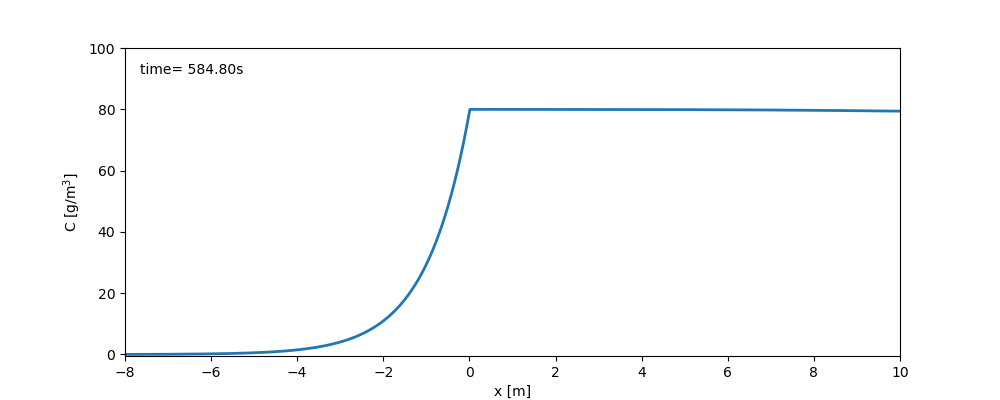

interactive(children=(Play(value=0, description='step', interval=20, max=1000000, show_repeat=False), FloatSli…

''

In [23]:
# The main attraction: plot and define how C evolves with each timestep.

# Plot C vs x
fig,ax=plt.subplots(figsize=[10,4])
l=ax.plot(x,Cnum,lw=2)[0] # keep a handle to the plot of concentration
def t_str():
    return f"time={t:7.2f}s"
t_label=ax.text(0.02,0.95,t_str(),transform=ax.transAxes,va='top')
ax.axis(xmin=x[0],xmax=x[-1],ymin=-0.5,ymax=100) # for default values [0,100] is a good y range.
ax.set_xlabel('x [m]')
ax.set_ylabel('C [g/m$^3$]')

# ____BEGIN 200B CONTENT____
# Implicit diffusion operator is mat_imp=I+D*dt/dx**2 * F
I=sparse.eye(N)
# F is the part of operator that scales with Dnum*dt/dx
d0=2*np.ones(N)
dp1=-np.ones(N)
dp1[1]*=2
dm1=-np.ones(N)
# dm1[-2:]*=2 # zero diffusive flux on downstream BC
dm1[-2:]=0
d0[-1]=0
F=sparse.spdiags( [dm1,d0,dp1], [-1,0,1], N, N).tocsr()

def plot_update(step,D,dt,src):
    global Dnum,Cnum,t,mdot 
    Dnum=D
    mdot=src
    
    if step==0: # reset to initial condition.
        Cnum=np.zeros_like(x)
        t=0.0
    else:
        t+=dt
        # Step forward in time
        # Advection:
        Cnum=np.interp(x,x+dt*unum,Cnum,left=0,right=0)
        # Source w/advection
        # add Csrc=mdot/u for the interval [0,u*dt]
        # integrate to get the cumulative distribution, then interpolate
        # and diff to get discrete distribution:
        # for x<0, cdf is 0.
        # over [0,u*dt] this should ramp up to mdot*dt 
        # Make an x coord array for the edge of the control volumes
        # The cumulative mass over [-inf,x_i] for each x_i in xedge,
        # for mass released over [0,dt]
        cmdf_x=np.interp( xedge, [0,unum*dt], [0,mdot*dt])
        mdf_x=np.diff(cmdf_x) # mass per CV
        Cnum[:]+=mdf_x/dx # concentratino per CV

        # Diffusion:
        mat_imp = I+Dnum*dt/dx**2*F
        Cnum=sparse.linalg.spsolve(mat_imp.tocsr(),Cnum)
    # Update the plot
    l.set_ydata(Cnum)
    t_label.set_text(t_str())

# ____END 200B content____
    
widgets.interact(plot_update,
                 step=widgets.Play(value=0,
                                   min=0, max=1000000,
                                   step=1, interval=20,
                                   show_repeat=False),
                 D=widgets.FloatSlider(value=0.05,min=0,max=1.0,step=0.001,
                                        description='D:',readout_format='.3f'),
                 src=widgets.FloatSlider(value=4.0,min=0,max=10.0, step=0.01,description='mdot'),
                 dt=widgets.FloatSlider(value=0.4,min=0.01,max=4.0,step=0.01,
                                        description='timestep:', readout_format='.2f')
                )
;

Analytical solution at steady state
--

The simulation may or may not be correct!  Solve for the steady state $C(x)$ and compare to the simulation.

The equation we're trying to solve is:
$$ \frac{\partial C}{\partial t} + u\frac{\partial C}{\partial x} = D \frac{\partial^2 C}{\partial x^2} + \dot{m}\delta(x)$$

The Peclet number tells us that as we get far from the source, advection dominates (taking $L\sim|x|$, recall $Pe\equiv \frac{UL}{D}$, and $Pe \gg 1$ implies advection-dominated). In our infinite domain, we can evaluate the behavior as $x$ goes to $\pm \infty$ by considering only advection.

 * For $x\rightarrow -\infty$: mass from the source is introduced downstream and flowing in the opposite direction, so $C_{-\infty}=0$
 * For $x\rightarrow \infty$: the advective flux is $J_A=uC$ and at steady state this must match the mass introduce by the source, 
   $\dot{m}$. Thus the concentration far downstream is $C_{+\infty}=\dot{m}/u$.

We now have suitable boundary conditions. What happens near $x=0$? The point source at the origin introduces a delta function $\dot{m} \delta(x)$ into the equation. Drop the unsteadiness term and integrate. Note that $\int \delta(x) = H(x)$, the Heaviside step function.

$$ uC = D \frac{dC}{dx} + \dot{m} H(x) + A $$   

with a constant of integration $A$.

For $x>0$,

$$uC -D \frac{dC}{dx} = \dot{m} + A$$

Note that the left side is the net flux, with advective and diffusive contributions. All mass introduced at the sources eventually advects towards $+\infty$, such that the net flux must be $J_{net}|_{x>0} = \dot{m}$ (remember $\dot{m}$ is for a 1-D source, per unit area in the $y-z$ plane, same units as $J$), and the constant of integration $A=0$. 

This is a *nonhomogeneous* ODE, and has a solution:

$$ C|_{x>0} = B e^\frac{ux}{D} + \dot{m}/u $$

Where $B$ is from another constant of integration. Knowing that $C(x)$ goes to $\dot{m}/u$ as $x\rightarrow\infty$, $B=0$, $C=\dot{m}/u$ for $x>0$.

For $x<0$, the step function $H(x<0)=0$, and we can solve to get:

$$C|_{x<0}=C|_0 e^{ux/D}$$

For $D>0$, at steady state we require that the diffusive flux is finite, and specifically $\partial C/\partial x$ is finite. Thus there cannot be a discontinuity across $x=0$, and $C|_0=\dot{m}/u$. The final solution is then:

$$C(x) = 
\left\{\begin{array}{ll}
\frac{\dot{m}}{u} e^{ux/D}, & x<0 \\
\frac{\dot{m}}{u}, & x>=0 \\
\end{array}
\right.
$$

Plot that on top of the simulation results!


In [22]:
# Overlay the analytical solution at steady state
C0=mdot/unum # steady state concentration for x>0
left=(x<=0) 

Csoln=np.where( x<0, 
                C0*np.exp(unum*x/max(Dnum,1e-6)),
                C0 )
ax.plot(x,Csoln,'k--',lw=5,alpha=0.5) ;